In [1]:
import sys
sys.path.append('../')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt

from util.true_gaussian_process import *

from ofm_OT_likelihood import *
from models.fno import FNO

import statsmodels.api as sm
from scipy.stats import binned_statistic


from sklearn.gaussian_process.kernels import WhiteKernel, Matern, RBF

from sklearn.gaussian_process import GaussianProcessRegressor
import os

from torchvision.transforms.functional import rotate
import torch.nn.functional as F

import torchvision
from torchvision import transforms
from torch.utils.data import Subset
import scipy
import os

In [3]:
# Code for regression part is modified from code from "universal functional regression with neural operator flows"
n_x = 64
dims = [n_x, n_x]

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
#spath = Path('../trash/GP')
spath = Path('your_path/NS')

spath.mkdir(parents=True, exist_ok=True)
saved_model = True # save model

# FNO hyperparameters
torch.manual_seed(22) # fix the seed for reproducible regression result
modes = 32 # can be applied to 32x32, or 128x128
width = 128
mlp_width = 128

# GP hyperparameters
kernel_length=0.01
kernel_variance=1
nu = 0.5 # default

## training parameters
epochs = 500
sigma_min=1e-4
N = 1
batch_size = 256

In [4]:
def compute_acovf(z):
    # z shape : [n, ndim, ndim]
    res = z.shape[-1]
    z_hat = torch.fft.rfft2(z)
    acf = torch.fft.irfft2(torch.conj(z_hat) * z_hat)
    acf = torch.fft.fftshift(acf).mean(dim=0) / z[0].numel() # ndim*ndim
    acf_r = acf.view(-1).cpu().detach().numpy()
    lags_x, lags_y = torch.meshgrid(torch.arange(res) - res//2, torch.arange(res) - res//2)
    lags_r = torch.sqrt(lags_x**2 + lags_y**2).view(-1).cpu().detach().numpy()

    idx = np.argsort(lags_r)
    lags_r = lags_r[idx]
    acf_r = acf_r[idx]

    bin_means, bin_edges, binnumber = binned_statistic(lags_r, acf_r, 'mean', bins=np.linspace(0.0, res, 50))
    return bin_edges[:-1], bin_means

In [5]:
x_test = np.load('data/N_S/ns_20000_4000_test.npy')

In [6]:
x_test = torch.Tensor(x_test)
#x_test = x_test[:,:,::2,::2]

## load trained model

In [7]:
spath

PosixPath('/net/ghisallo/scratch1/yshi5/OFM/NS')

In [8]:
## load trained model
model = FNO(modes, vis_channels=1, hidden_channels=width, proj_channels=mlp_width, x_dim=2, t_scaling=1).to(device)
 
for param in model.parameters():
    param.requires_grad = False
    
# paper :model_path = path "paper_saved_models/{}/1D_codomain_649_set1.pt".format(folder)
model_path = os.path.join(spath, 'epoch_500.pt')
checkpoint = torch.load(model_path, map_location='cpu', weights_only=True)
model.load_state_dict(checkpoint)

fmot = OFMModel(model, kernel_length=kernel_length, kernel_variance=kernel_variance, nu=nu, sigma_min=sigma_min, device=device, dims=dims)

## statistical features

In [9]:
x_hist_true, bin_edges = x_test.histogram(range=[-4,4], density=True)
x_pos = np.linspace(0, 1, n_x)

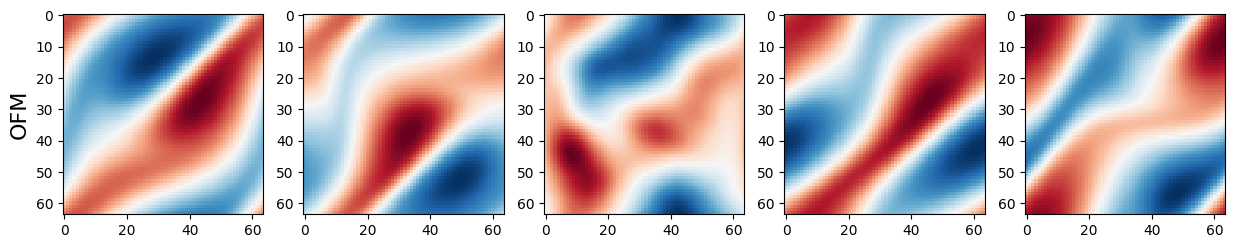

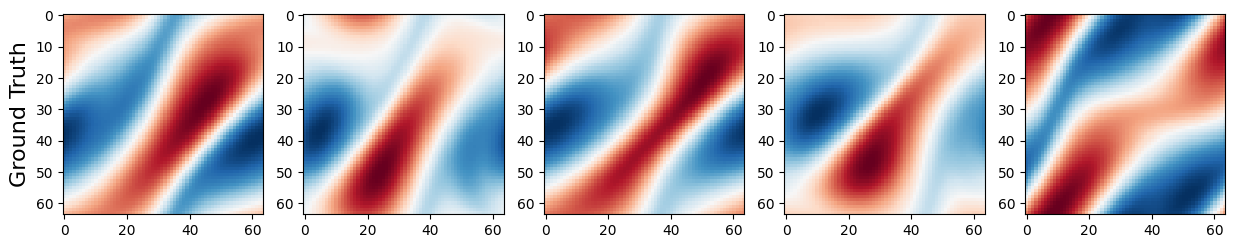

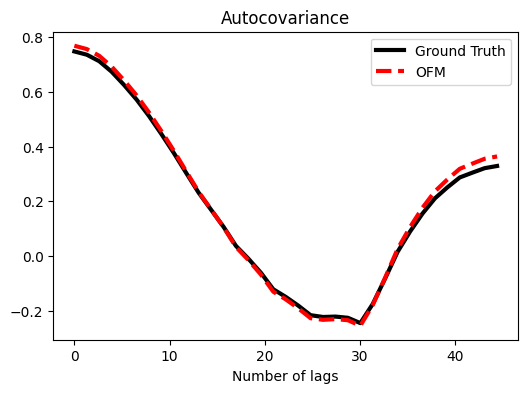

In [12]:
with torch.no_grad():

    X_hat = fmot.sample([n_x, n_x], n_samples=10, n_eval=10).cpu()
    #X_hat = torch.exp(X_hat*x_std + x_mean).squeeze()
    
    X_ground_truth = x_test[:5].squeeze()
    # plot
    
    X_alt = []
    for i in range(5):
        X_temp = fmot.sample([n_x, n_x], n_samples=200, n_eval=10).cpu().squeeze()
        X_alt.append(X_temp)
        
    X_alt = torch.vstack(X_alt)
    #X_alt = torch.exp(X_alt * x_std + x_mean)
    
    bin_center, x_acovf = compute_acovf(X_alt.squeeze())
    #x_test = torch.exp(x_test*x_std + x_mean)
    _, x_acovf_true = compute_acovf(x_test.squeeze())
    x_hist, bin_edges_alt = X_alt.histogram(range=[-4,4], density=True)
    x_hist_true, bin_edges = x_test.histogram(range=[-4, 4], density=True)
    
    fig, ax = plt.subplots(1,5, figsize=(15,3))
    for i in range(5):
        x = X_hat[i,:,:].squeeze()

        ax[i].imshow(x,cmap="RdBu_r")#, vmin=-2, vmax=2)
        if i == 0:
            ax[i].set_ylabel('OFM', fontsize=16)
        
    #cb = fig.colorbar(ax[4].imshow(), , orientation='vertical')
    #bar = ax[4].imshow(x)#, vmin=-2, vmax=2)
    #fig.colorbar(bar, ax=ax)
    #plt.show()

    
    fig, ax = plt.subplots(1,5, figsize=(15,3))    
    for i in range(5):
        x_ground_truth = X_ground_truth[i,:,:].squeeze()
        ax[i].imshow(x_ground_truth,cmap="RdBu_r")#, vmin=-2, vmax=2)
        if i == 0:
            ax[i].set_ylabel('Ground Truth', fontsize=16)
    #plt.savefig(f"../Generation_results/{paper_folder}/NS_gt_samples.pdf")
    #bar = ax[4].imshow(x_ground_truth) #, vmin=-2, vmax=2)
    #fig.colorbar(bar, ax=ax)
   
    fig, ax = plt.subplots(1,1, figsize=(6,4))
    ax.plot(bin_center, x_acovf_true, c='k', lw=3, label='Ground Truth')
    ax.plot(bin_center, x_acovf, c='r',ls='--', lw=3, label='OFM')
    #ax[0].set_ylim(0.2, 0.45)
    ax.set_title('Autocovariance')
    ax.set_xlabel('Number of lags')
    ax.legend(loc='upper right')


## 2D Regression

$$\log \mathbb{P} \left( \lbrace u(x_i) \rbrace_{i=1}^m \Big| \lbrace \widehat u(x_i) \rbrace_{i=1}^n \right) =  -\frac{\sum_{i=1}^n \lVert \widehat u(x_i) - u(x_i) \rVert^2}{2\sigma^2} + \log \mathbb{P} \left( \lbrace u(x_i) \rbrace_{i=1}^m \right) + C  
$$

In [11]:
# lr : learning rate used in MAP estimation
# noise_level: a predefined noise-level, \sigma^2

ndim = 64
lr = 1e-3 
epochs = 2000
noise_level = 0.001

# extract 32 random observations from a test sample
berno_mask = torch.zeros((ndim, ndim))

mask_idx = np.random.choice(ndim*ndim, 32,replace=False)

berno_mask.reshape(-1)[mask_idx] = 1

berno_mask = berno_mask.reshape(ndim,ndim)
pos_mask = (berno_mask == 1)

# The ground truth that we used to extract random observation
u_obs_full = x_test[0:1,:]
u_obs_part = u_obs_full[:,:, pos_mask].to(device)

# generate noisy observation by injecting white noise
noise_pattern =  torch.randn_like(u_obs_part)
u_obs_part = u_obs_part + noise_pattern* np.sqrt(noise_level)

# saved for further use
u_obs_full = u_obs_full.squeeze()
u_obs_part_detach = u_obs_part.detach().cpu()

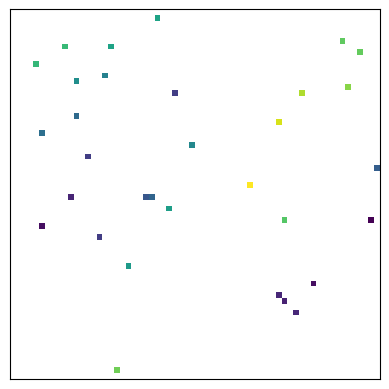

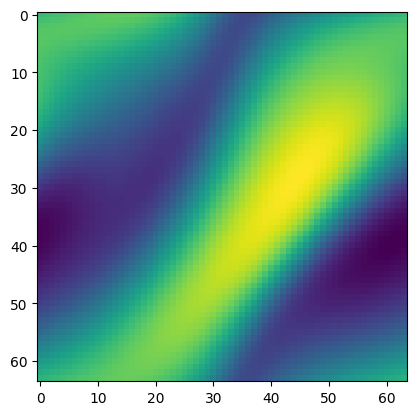

In [12]:
# for plotting the partial observation
add_noise_plot = torch.zeros((ndim, ndim))
add_noise_plot[pos_mask] = add_noise_plot[pos_mask] + (noise_pattern.detach().cpu()* np.sqrt(noise_level)).squeeze()

part_gt = u_obs_full.clone() + add_noise_plot

part_gt[~pos_mask] = np.nan
# plot the partial observation 
plt.imshow(part_gt)

plt.xticks([])
plt.yticks([])
#plt.title('Partial Observation', fontsize=16)
#plt.tight_layout()

#plt.savefig('./demo_figure.png', transparent=True)
plt.show()
plt.figure()
plt.imshow(x_test[0,0])

In [13]:
G = fmot

In [14]:
class regression_opflow_a(nn.Module):
    def __init__(self, G):
        super().__init__()
        self.G = G
        self.a_target = nn.Parameter(torch.zeros(1,1, ndim, ndim))
                                       
    def initialize(self, input):
        self.a_target.data = input.to(device)
        
    def target_u(self):
        return self.G.inv_sample(self.a_target, n_eval=2, forward=True)
        
    def logp(self):
        
        """
        take more time to average out, average out over the first dimension.
        Reduce time complexity by increasing the space complexity 
        """
        u, out_logp, prior_logp = self.G.data_likelihood_precise(self.a_target, n_eval=4, forward=True,n_repeat=8)   
            
        return u, out_logp

    
def reg_process_a(reg_opflw_a, reg_optim_a, epochs, reg_scheduler=None):
    losses = np.zeros(epochs)
    for epoch in range(epochs):
        # maximize a posterior 
        reg_optim_a.zero_grad()
        cur_u, cur_logp = reg_opflow_a.logp()
        
        #loss1 = -0.5*torch.sum((u_obs_part - reg_opflow_a.target_u()[:, :, pos_mask])**2)/noise_level
        #loss2 = reg_opflow_a.logp()
        loss1 = -0.5*torch.sum((u_obs_part - cur_u[:, pos_mask])**2)/noise_level
        loss2 = cur_logp
        
        loss = -(loss1 + loss2)
        loss.backward()
        reg_optim_a.step()
        losses[epoch] = loss.item()
        if reg_scheduler is not None:
            reg_scheduler.step()
        print("epcoh:{}, loss:{}".format(epoch, loss.item()))
    return losses

In [15]:
reg_opflow_a = regression_opflow_a(G).to(device)
reg_optim_a = torch.optim.Adam(reg_opflow_a.parameters(), lr=lr , weight_decay=1e-4)

In [17]:
losses = reg_process_a(reg_opflow_a, reg_optim_a, epochs)

epcoh:0, loss:61939.77734375
epcoh:1, loss:62134.88671875
epcoh:2, loss:62329.63671875
epcoh:3, loss:62283.8046875
epcoh:4, loss:62180.32421875
epcoh:5, loss:62172.59765625
epcoh:6, loss:62418.6875
epcoh:7, loss:62217.59375
epcoh:8, loss:62191.078125
epcoh:9, loss:62421.20703125
epcoh:10, loss:62457.36328125
epcoh:11, loss:62554.7265625
epcoh:12, loss:62588.26953125
epcoh:13, loss:62661.203125
epcoh:14, loss:62720.921875
epcoh:15, loss:63146.953125
epcoh:16, loss:63201.2109375
epcoh:17, loss:63251.17578125
epcoh:18, loss:63550.6015625
epcoh:19, loss:63482.62109375
epcoh:20, loss:63339.2578125
epcoh:21, loss:63856.4921875
epcoh:22, loss:63894.26171875
epcoh:23, loss:63906.51171875
epcoh:24, loss:64113.80859375
epcoh:25, loss:64340.75390625
epcoh:26, loss:64706.05859375
epcoh:27, loss:64957.30078125
epcoh:28, loss:65195.06640625
epcoh:29, loss:65231.90234375
epcoh:30, loss:65255.046875
epcoh:31, loss:65322.1953125
epcoh:32, loss:65628.390625
epcoh:33, loss:65998.4453125
epcoh:34, loss:66

epcoh:285, loss:89829.6484375
epcoh:286, loss:89922.53125
epcoh:287, loss:89929.3203125
epcoh:288, loss:89315.125
epcoh:289, loss:88983.6640625
epcoh:290, loss:88912.46875
epcoh:291, loss:88736.1640625
epcoh:292, loss:88334.5703125
epcoh:293, loss:88088.0859375
epcoh:294, loss:88449.734375
epcoh:295, loss:88221.84375
epcoh:296, loss:88154.578125
epcoh:297, loss:87629.0859375
epcoh:298, loss:87864.2421875
epcoh:299, loss:87482.9453125
epcoh:300, loss:87240.3125
epcoh:301, loss:87305.7734375
epcoh:302, loss:87227.875
epcoh:303, loss:87191.0
epcoh:304, loss:86930.46875
epcoh:305, loss:86984.5078125
epcoh:306, loss:86659.0703125
epcoh:307, loss:86271.5859375
epcoh:308, loss:86240.3359375
epcoh:309, loss:85978.3203125
epcoh:310, loss:85503.359375
epcoh:311, loss:85420.25
epcoh:312, loss:85548.015625
epcoh:313, loss:85358.2890625
epcoh:314, loss:85162.421875
epcoh:315, loss:85287.5078125
epcoh:316, loss:85253.171875
epcoh:317, loss:85040.46875
epcoh:318, loss:84886.625
epcoh:319, loss:84496.

epcoh:567, loss:68876.921875
epcoh:568, loss:69225.171875
epcoh:569, loss:68862.7265625
epcoh:570, loss:69370.9921875
epcoh:571, loss:69336.1796875
epcoh:572, loss:68937.1953125
epcoh:573, loss:68561.0546875
epcoh:574, loss:69164.0234375
epcoh:575, loss:68579.015625
epcoh:576, loss:68636.9375
epcoh:577, loss:68876.578125
epcoh:578, loss:68720.1328125
epcoh:579, loss:69311.984375
epcoh:580, loss:68929.5703125
epcoh:581, loss:68881.3984375
epcoh:582, loss:68280.59375
epcoh:583, loss:68525.1328125
epcoh:584, loss:68794.40625
epcoh:585, loss:68725.6484375
epcoh:586, loss:68835.3125
epcoh:587, loss:68681.484375
epcoh:588, loss:68702.96875
epcoh:589, loss:68554.09375
epcoh:590, loss:68367.8203125
epcoh:591, loss:68520.125
epcoh:592, loss:68726.71875
epcoh:593, loss:68333.3359375
epcoh:594, loss:68417.7890625
epcoh:595, loss:68364.1875
epcoh:596, loss:68521.5
epcoh:597, loss:68333.2265625
epcoh:598, loss:68283.125
epcoh:599, loss:68097.15625
epcoh:600, loss:68354.90625
epcoh:601, loss:68360.8

epcoh:846, loss:63879.140625
epcoh:847, loss:63862.03125
epcoh:848, loss:63702.31640625
epcoh:849, loss:63950.68359375
epcoh:850, loss:63656.4375
epcoh:851, loss:63777.76953125
epcoh:852, loss:63808.23828125
epcoh:853, loss:63840.50390625
epcoh:854, loss:63552.21875
epcoh:855, loss:63571.16015625
epcoh:856, loss:63601.171875
epcoh:857, loss:63325.2890625
epcoh:858, loss:63461.48046875
epcoh:859, loss:63662.48046875
epcoh:860, loss:63647.375
epcoh:861, loss:63414.73046875
epcoh:862, loss:63551.87109375
epcoh:863, loss:63628.56640625
epcoh:864, loss:63540.3515625
epcoh:865, loss:63594.91796875
epcoh:866, loss:63369.3828125
epcoh:867, loss:63764.4453125
epcoh:868, loss:63118.6171875
epcoh:869, loss:63484.90234375
epcoh:870, loss:63431.20703125
epcoh:871, loss:63302.0390625
epcoh:872, loss:63191.09765625
epcoh:873, loss:63401.75390625
epcoh:874, loss:63253.40625
epcoh:875, loss:63714.640625
epcoh:876, loss:63575.59375
epcoh:877, loss:63216.640625
epcoh:878, loss:63321.90625
epcoh:879, loss

epcoh:1116, loss:61309.82421875
epcoh:1117, loss:61586.7734375
epcoh:1118, loss:61110.30859375
epcoh:1119, loss:61675.98046875
epcoh:1120, loss:61705.28125
epcoh:1121, loss:61486.29296875
epcoh:1122, loss:61625.5859375
epcoh:1123, loss:61441.890625
epcoh:1124, loss:61573.44921875
epcoh:1125, loss:61494.953125
epcoh:1126, loss:61304.9921875
epcoh:1127, loss:61326.765625
epcoh:1128, loss:61256.796875
epcoh:1129, loss:61143.15234375
epcoh:1130, loss:61289.26171875
epcoh:1131, loss:61184.91796875
epcoh:1132, loss:61161.54296875
epcoh:1133, loss:61039.13671875
epcoh:1134, loss:61226.45703125
epcoh:1135, loss:61479.984375
epcoh:1136, loss:61290.30859375
epcoh:1137, loss:61266.7734375
epcoh:1138, loss:61030.9296875
epcoh:1139, loss:61156.69140625
epcoh:1140, loss:60758.82421875
epcoh:1141, loss:60981.30078125
epcoh:1142, loss:61085.78125
epcoh:1143, loss:61140.36328125
epcoh:1144, loss:61369.8984375
epcoh:1145, loss:61080.58984375
epcoh:1146, loss:60973.1875
epcoh:1147, loss:61267.09765625
ep

epcoh:1381, loss:59392.03125
epcoh:1382, loss:58899.71875
epcoh:1383, loss:59112.45703125
epcoh:1384, loss:59453.48828125
epcoh:1385, loss:59375.6328125
epcoh:1386, loss:59386.6640625
epcoh:1387, loss:59718.17578125
epcoh:1388, loss:59262.39453125
epcoh:1389, loss:59471.33203125
epcoh:1390, loss:59007.18359375
epcoh:1391, loss:59358.703125
epcoh:1392, loss:59290.125
epcoh:1393, loss:59491.85546875
epcoh:1394, loss:59159.39453125
epcoh:1395, loss:59306.39453125
epcoh:1396, loss:59602.140625
epcoh:1397, loss:59170.92578125
epcoh:1398, loss:59020.3125
epcoh:1399, loss:59272.12890625
epcoh:1400, loss:59357.76171875
epcoh:1401, loss:59310.95703125
epcoh:1402, loss:59307.3984375
epcoh:1403, loss:59227.0859375
epcoh:1404, loss:59096.86328125
epcoh:1405, loss:59319.34765625
epcoh:1406, loss:59018.37109375
epcoh:1407, loss:59151.2734375
epcoh:1408, loss:58816.9375
epcoh:1409, loss:59189.30859375
epcoh:1410, loss:59017.69921875
epcoh:1411, loss:58845.8359375
epcoh:1412, loss:59136.40625
epcoh:14

epcoh:1645, loss:57834.22265625
epcoh:1646, loss:57667.45703125
epcoh:1647, loss:57505.703125
epcoh:1648, loss:57691.34765625
epcoh:1649, loss:57309.2421875
epcoh:1650, loss:57690.23046875
epcoh:1651, loss:57558.14453125
epcoh:1652, loss:57492.92578125
epcoh:1653, loss:57857.453125
epcoh:1654, loss:57609.1484375
epcoh:1655, loss:57509.20703125
epcoh:1656, loss:57360.45703125
epcoh:1657, loss:57493.890625
epcoh:1658, loss:57340.0
epcoh:1659, loss:57699.51953125
epcoh:1660, loss:57919.0078125
epcoh:1661, loss:57556.28125
epcoh:1662, loss:57418.8359375
epcoh:1663, loss:57439.8984375
epcoh:1664, loss:57778.48828125
epcoh:1665, loss:57427.23828125
epcoh:1666, loss:57295.36328125
epcoh:1667, loss:57567.44921875
epcoh:1668, loss:57499.81640625
epcoh:1669, loss:57671.98828125
epcoh:1670, loss:57487.88671875
epcoh:1671, loss:57529.0703125
epcoh:1672, loss:57222.046875
epcoh:1673, loss:57114.66796875
epcoh:1674, loss:57456.3046875
epcoh:1675, loss:57759.13671875
epcoh:1676, loss:57389.2109375
ep

epcoh:1909, loss:56417.3046875
epcoh:1910, loss:56215.5234375
epcoh:1911, loss:56154.7734375
epcoh:1912, loss:55937.8671875
epcoh:1913, loss:56259.98046875
epcoh:1914, loss:56148.953125
epcoh:1915, loss:56179.8515625
epcoh:1916, loss:56145.34375
epcoh:1917, loss:55932.21484375
epcoh:1918, loss:55906.6796875
epcoh:1919, loss:56211.8203125
epcoh:1920, loss:56179.453125
epcoh:1921, loss:55978.734375
epcoh:1922, loss:56094.69140625
epcoh:1923, loss:56186.79296875
epcoh:1924, loss:55895.32421875
epcoh:1925, loss:55916.6875
epcoh:1926, loss:55966.55078125
epcoh:1927, loss:56214.01953125
epcoh:1928, loss:56060.4140625
epcoh:1929, loss:56195.8828125
epcoh:1930, loss:55947.53125
epcoh:1931, loss:56281.2421875
epcoh:1932, loss:56361.3671875
epcoh:1933, loss:56146.4453125
epcoh:1934, loss:56063.765625
epcoh:1935, loss:56250.515625
epcoh:1936, loss:56263.9140625
epcoh:1937, loss:56098.6875
epcoh:1938, loss:55838.234375
epcoh:1939, loss:56317.77734375
epcoh:1940, loss:56145.55078125
epcoh:1941, los

epcoh:2175, loss:54736.0234375
epcoh:2176, loss:54598.1015625
epcoh:2177, loss:54515.79296875
epcoh:2178, loss:54773.04296875
epcoh:2179, loss:54526.25390625
epcoh:2180, loss:54471.4453125
epcoh:2181, loss:54780.21484375
epcoh:2182, loss:54460.16015625
epcoh:2183, loss:54728.91796875
epcoh:2184, loss:54332.09765625
epcoh:2185, loss:54675.796875
epcoh:2186, loss:54432.75
epcoh:2187, loss:54599.16796875
epcoh:2188, loss:54488.23828125
epcoh:2189, loss:54696.5546875
epcoh:2190, loss:54658.515625
epcoh:2191, loss:54319.8203125
epcoh:2192, loss:54579.4921875
epcoh:2193, loss:54310.140625
epcoh:2194, loss:54553.26171875
epcoh:2195, loss:54339.1875
epcoh:2196, loss:54241.82421875
epcoh:2197, loss:54103.00390625
epcoh:2198, loss:54404.34765625
epcoh:2199, loss:54692.3984375
epcoh:2200, loss:54573.41796875
epcoh:2201, loss:54667.61328125
epcoh:2202, loss:54367.77734375
epcoh:2203, loss:54497.58984375
epcoh:2204, loss:54327.2421875
epcoh:2205, loss:54503.12890625
epcoh:2206, loss:54264.2109375
e

epcoh:2441, loss:52737.59765625
epcoh:2442, loss:52688.33203125
epcoh:2443, loss:52842.72265625
epcoh:2444, loss:52788.0546875
epcoh:2445, loss:52744.08984375
epcoh:2446, loss:52735.6171875
epcoh:2447, loss:52780.1796875
epcoh:2448, loss:52706.1328125
epcoh:2449, loss:52544.4765625
epcoh:2450, loss:52868.90234375
epcoh:2451, loss:52685.44140625
epcoh:2452, loss:52629.08203125
epcoh:2453, loss:52720.69921875
epcoh:2454, loss:52747.23046875
epcoh:2455, loss:52412.44921875
epcoh:2456, loss:52562.2421875
epcoh:2457, loss:52579.984375
epcoh:2458, loss:52748.44921875
epcoh:2459, loss:52618.75390625
epcoh:2460, loss:52724.734375
epcoh:2461, loss:52563.23046875
epcoh:2462, loss:52715.4921875
epcoh:2463, loss:52393.03515625
epcoh:2464, loss:52409.46875
epcoh:2465, loss:52611.8125
epcoh:2466, loss:52549.90234375
epcoh:2467, loss:52372.37109375
epcoh:2468, loss:52574.99609375
epcoh:2469, loss:52487.68359375
epcoh:2470, loss:52520.8828125
epcoh:2471, loss:52366.1171875
epcoh:2472, loss:52509.55859

epcoh:2705, loss:51714.5859375
epcoh:2706, loss:52104.97265625
epcoh:2707, loss:51635.21875
epcoh:2708, loss:51914.06640625
epcoh:2709, loss:51650.8828125
epcoh:2710, loss:51712.8984375
epcoh:2711, loss:51815.72265625
epcoh:2712, loss:51847.50390625
epcoh:2713, loss:51638.8359375
epcoh:2714, loss:51521.453125
epcoh:2715, loss:51825.16796875
epcoh:2716, loss:51863.30078125
epcoh:2717, loss:51708.125
epcoh:2718, loss:51714.796875
epcoh:2719, loss:51717.0
epcoh:2720, loss:51864.015625
epcoh:2721, loss:51891.62109375
epcoh:2722, loss:51853.453125
epcoh:2723, loss:51703.6640625
epcoh:2724, loss:51662.0859375
epcoh:2725, loss:51899.71875
epcoh:2726, loss:51902.1171875
epcoh:2727, loss:51623.5625
epcoh:2728, loss:51917.60546875
epcoh:2729, loss:51713.80078125
epcoh:2730, loss:51545.48046875
epcoh:2731, loss:51625.5546875
epcoh:2732, loss:51627.96875
epcoh:2733, loss:51789.87890625
epcoh:2734, loss:51590.33984375
epcoh:2735, loss:51805.98828125
epcoh:2736, loss:51800.0625
epcoh:2737, loss:5192

epcoh:2970, loss:51769.0703125
epcoh:2971, loss:52105.08203125
epcoh:2972, loss:51724.671875
epcoh:2973, loss:51517.48828125
epcoh:2974, loss:51604.2265625
epcoh:2975, loss:51882.74609375
epcoh:2976, loss:51537.9609375
epcoh:2977, loss:51624.87109375
epcoh:2978, loss:51704.6484375
epcoh:2979, loss:51582.1640625
epcoh:2980, loss:51600.2109375
epcoh:2981, loss:51555.890625
epcoh:2982, loss:51460.15625
epcoh:2983, loss:51844.59765625
epcoh:2984, loss:51847.796875
epcoh:2985, loss:51740.859375
epcoh:2986, loss:51806.53515625
epcoh:2987, loss:51592.62890625
epcoh:2988, loss:51620.98828125
epcoh:2989, loss:51819.75
epcoh:2990, loss:51987.828125
epcoh:2991, loss:51586.9296875
epcoh:2992, loss:51823.2265625
epcoh:2993, loss:51879.31640625
epcoh:2994, loss:51711.859375
epcoh:2995, loss:51414.5546875
epcoh:2996, loss:51536.921875
epcoh:2997, loss:51779.703125
epcoh:2998, loss:51470.140625
epcoh:2999, loss:51634.35546875


In [18]:
def plot_gpr_samples(gpr_model, n_samples, ax):
    """Plot samples drawn from the Gaussian process model.

    If the Gaussian process model is not trained then the drawn samples are
    drawn from the prior distribution. Otherwise, the samples are drawn from
    the posterior distribution. Be aware that a sample here corresponds to a
    function.

    Parameters
    ----------
    gpr_model : `GaussianProcessRegressor`
        A :class:`~sklearn.gaussian_process.GaussianProcessRegressor` model.
    n_samples : int
        The number of samples to draw from the Gaussian process distribution.
    ax : matplotlib axis
        The matplotlib axis where to plot the samples.
    """
    x = np.linspace(0, 1, ndim)
    X = x.reshape(-1, 1)

    y_mean, y_std = gpr_model.predict(X, return_std=True)
    y_samples = gpr_model.sample_y(X, n_samples)

    for idx, single_prior in enumerate(y_samples.T):
        ax.plot(
            x,
            single_prior,
            linestyle="--",
            alpha=0.7,
            label=f"Sampled function #{idx + 1}",
        )
    ax.plot(x, y_mean, color="black", label="Mean")
    ax.fill_between(
        x,
        y_mean - y_std,
        y_mean + y_std,
        alpha=0.1,
        color="black",
        label=r"$\pm$ 1 std. dev.",
    )
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    #ax.set_ylim([-3, 3])

In [19]:
u_opflow = reg_opflow_a.target_u().detach() # u_opflow : [ndim, ndim]
u_opflow_old = u_opflow #save a copy

x = np.linspace(0, 1, ndim)
y = np.linspace(0, 1, ndim)
XX, YY = np.meshgrid(x, y)
XX = XX.reshape(-1, 1)
YY = YY.reshape(-1, 1)
X = np.concatenate([XX, YY], axis=1)
print(X.shape)

x_obs = X[pos_mask.reshape(-1)]
y_obs = u_obs_part.squeeze().detach().cpu().numpy()


(4096, 2)


In [20]:
x_obs = X[pos_mask.reshape(-1)]
y_obs = u_obs_part.squeeze().detach().cpu().numpy()


## SGLD

In [141]:
"""
# for arius, memory constrain
import gc
gc.collect()
torch.cuda.empty_cache()
print(torch.cuda.memory_summary()) 
"""


'\n# for arius, memory constrain\nimport gc\ngc.collect()\ntorch.cuda.empty_cache()\nprint(torch.cuda.memory_summary()) \n'

In [16]:
import sys
sys.path.insert(0, '../')

from imp import reload

import sampling_FSGLD

import sampling_FSGLD.samplers


import sampling_FSGLD.SGLD
reload(sampling_FSGLD.SGLD)

# reload order matter, sampler should be after sgld
reload(sampling_FSGLD.samplers)
from sampling_FSGLD.samplers import LangevinDynamics,MetropolisAdjustedLangevin

import copy
from tqdm import tqdm

/tmp/ipykernel_904466/3722995193.py:4: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


In [15]:
def nl_pdf_a(a, noise_level=noise_level):
    # return negative loglikehood

    cur_u, cur_logp, _ = G.data_likelihood_precise(a, n_eval=4, forward=True,n_repeat=8)
    loss1 = -0.5*torch.sum((u_obs_part - cur_u[:,  pos_mask])**2)/noise_level
    loss2 = cur_logp

    loss = -(loss1 + loss2)    
    
    return loss

In [24]:
### backup, skip if necessary
import h5py

saved_folder = 'GRF2NS_OFM_sup'

#f = h5py.File(f"../Regression_results/{saved_folder}/{saved_folder}.h5py", "r")
a_opflow_copy = np.array(f['a_opflow_map'])
reg_opflow_a.initialize(torch.Tensor(a_opflow_copy).unsqueeze(0).unsqueeze(1))



In [19]:
a_opflow_copy = reg_opflow_a.a_target.data.cpu().detach().clone()
u_opflow_copy = reg_opflow_a.target_u().cpu().detach().clone()

In [25]:

## initialize with the MAP result
x = torch.zeros_like(a_opflow_copy, requires_grad=True)
x.data = a_opflow_copy.to(device)
#x = nn.Parameter(u_opflow_copy, requires_grad=True).to(device)
#x = torch.zeros([2], requires_grad=True, device=device)

temperature = 1
momentum = 0

max_itr = int(2e4)
## should sample 6e4 to guarantee the smooth. 


# only designed for function SGLD
langevin_dynamics = LangevinDynamics(x,
                                     nl_pdf_a,
                                     lr=3e-3,
                                     lr_final=2e-3,
                                     max_itr=max_itr,
                                     pos_mask=pos_mask,
                                     device=device,
                                     temperature = temperature,
                                     momentum = momentum
                                     )

hist_samples = []
loss_log = []
for j in tqdm(range(max_itr)):
    est, loss = langevin_dynamics.sample(epoch=j)
    loss_log.append(loss)
    if j % 10 == 0:
        hist_samples.append(est.cpu().numpy())

update
Tempertaure:1
start, white noise on A


100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [13:15:01<00:00,  2.39s/it]


In [26]:
a_samples_all = torch.Tensor(np.vstack(hist_samples)).to(device)
#u_samples_all = G.inverse(a_samples_all)

import math
split_batch = 100
num_batches = math.ceil(a_samples_all.size()[0]/split_batch)
X_list = [a_samples_all[split_batch*y:split_batch*(y+1),:,:] for y in range(num_batches)]
print(X_list[0].size())

u_samples_all = []
with torch.no_grad():
    for cur_a_sample in X_list:
        u_samples_all.append(G.inv_sample(cur_a_sample, n_eval=4, forward=True).cpu().detach())
        
u_samples_all = torch.vstack(u_samples_all)

torch.Size([100, 1, 64, 64])


In [ ]:
fig = plt.figure("training logs - net", dpi=150, figsize=(7, 2.5))
plt.plot(np.arange(3000, len(loss_log)),loss_log[3000:])
#plt.title("Unnormalized PDF")
plt.xlabel("Iterations")
plt.ylabel('NLL')
#plt.ylabel(r"$- \log \ \mathrm{N}(\mathbf{x} | \mu, \Sigma) + const.$")
plt.grid()

In [32]:
## calculate the mean predicted from OpFlow and Ground Truht 
est_samples = u_samples_all.detach().cpu().numpy()
est_samples = est_samples[300:]


sample_mean = np.mean(est_samples, axis=0).squeeze()
sample_std = np.std(est_samples, axis=0).squeeze()

In [8]:
import h5py

In [10]:

opflow_mean = sample_mean
opflow_std = sample_std

x = np.linspace(0, 1, ndim)
y = np.linspace(0, 1, ndim)
XX, YY = np.meshgrid(x, y)
XX = XX.reshape(-1, 1)
YY = YY.reshape(-1, 1)
X = np.concatenate([XX, YY], axis=1)
print(X.shape)


(4096, 2)


In [ ]:
## Fit the best GP
#true_kernel = 1.0 * Matern(length_scale=0.5, length_scale_bounds=(1e-1, 0.5), nu=1.5)  + WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-2, 0.05))
true_kernel = 1.0 * RBF(length_scale=1.0) + WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-2, 0.05))

gpr = GaussianProcessRegressor(kernel=true_kernel, alpha=0)

gpr = gpr.fit(x_obs, y_obs) #update the GP model 

print(f"Initial: {true_kernel}\nOptimum: {gpr.kernel_}\nLog-Marginal-Likelihood: ")


In [19]:
# update the parameters, follow https://scikit-learn.org/1.5/modules/gaussian_process.html
true_kernel = 1.07**2 * RBF(length_scale=0.203)
gpr_model_ground_truth = GaussianProcessRegressor(kernel=true_kernel, alpha=0.01) # alpha determined from the whitekernel

gpr_model_ground_truth = gpr_model_ground_truth.fit(x_obs, y_obs) #update the GP model 


In [25]:
saved_folder = 'GRF2NS_OFM_sup'
if not os.path.exists(f"../Regression_results/{saved_folder}"):
    os.makedirs(f"../Regression_results/{saved_folder}")

In [26]:
from matplotlib.colors import TwoSlopeNorm

In [20]:
y_mean, y_std = gpr_model_ground_truth.predict(X, return_std=True)
y_mean = y_mean.reshape(ndim,ndim)
y_std = y_std.reshape(ndim,ndim)
y_samples = gpr_model_ground_truth.sample_y(X, 1000).reshape(ndim,ndim,-1)

### plot parameter
y_min_plot, y_max_plot = u_obs_full.min(), u_obs_full.max()


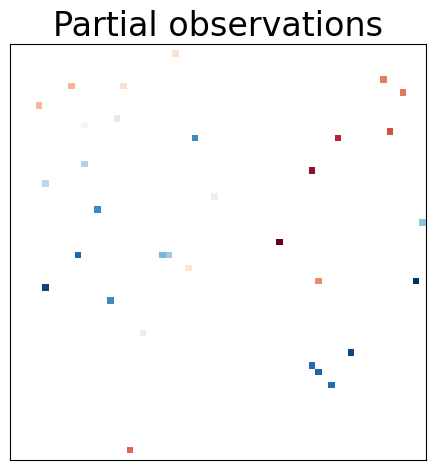

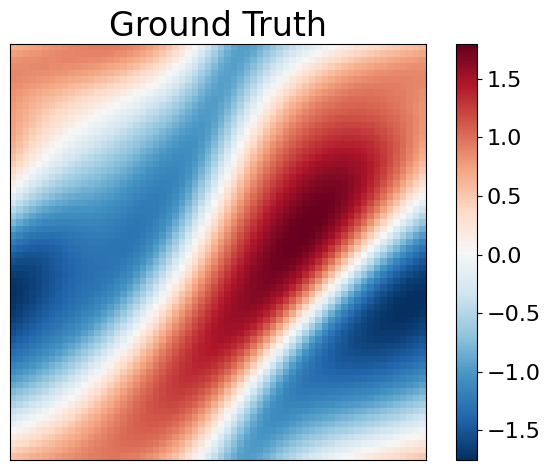

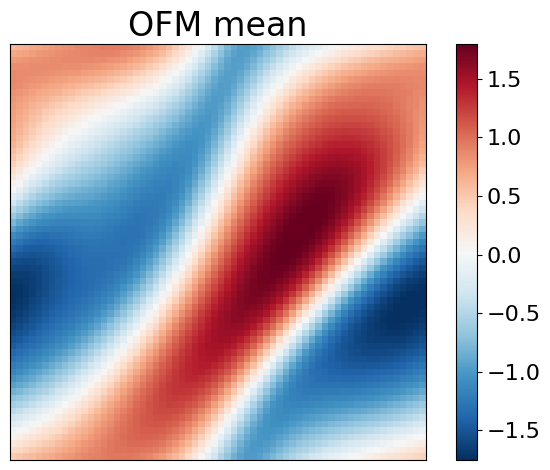

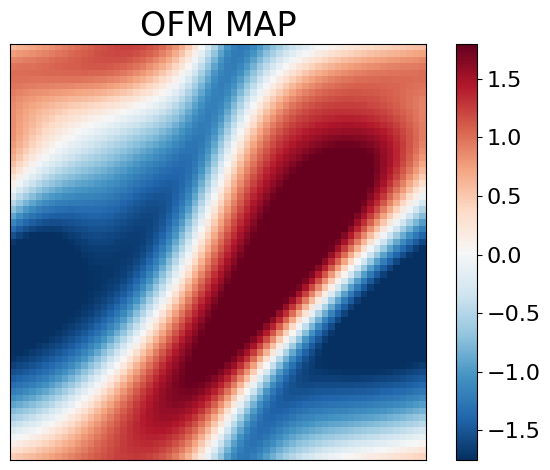

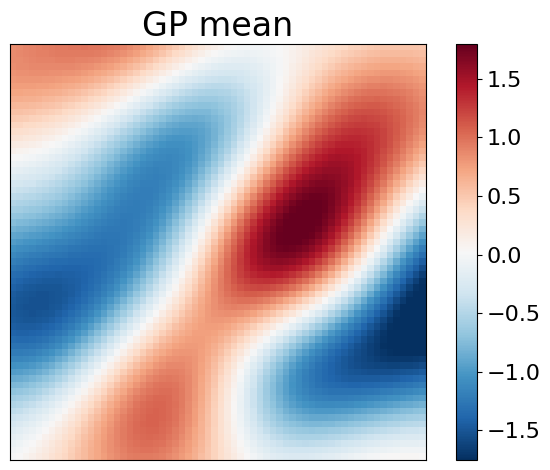

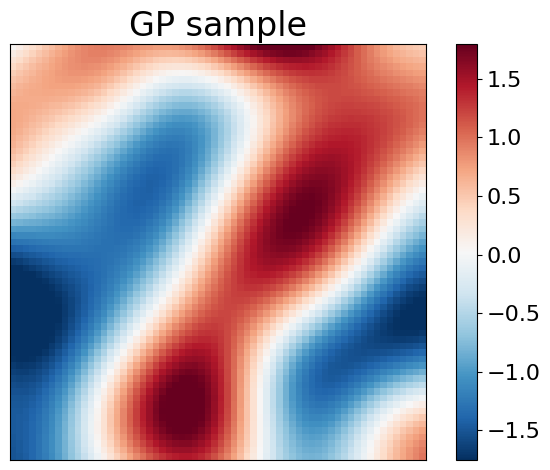

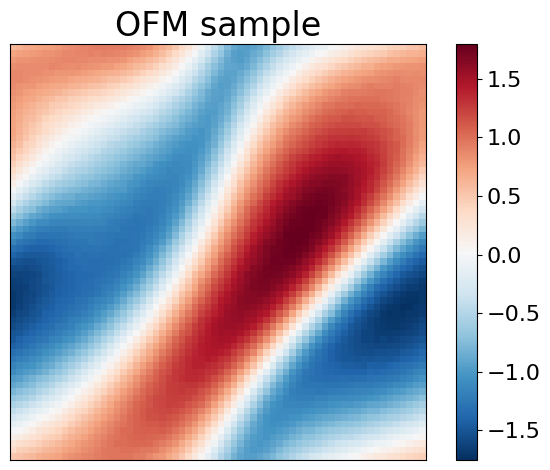

In [27]:

#y_abs_max = np.abs(y_mean).max()
# plot the partial observation 
plt.imshow(part_gt, cmap="RdBu_r")
plt.xticks([])
plt.yticks([])
plt.title('Partial observations', fontsize=24)
plt.tight_layout()
#plt.savefig(f"../Regression_results/{saved_folder}/NS_reg_partial_obs_sup.pdf")


plt.figure()
plt.imshow(u_obs_full, vmin=y_min_plot, vmax=y_max_plot, cmap="RdBu_r")
#plt.imshow(sample_mean)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=16)
plt.xticks([])
plt.yticks([])
plt.title('Ground Truth', fontsize=24)
plt.tight_layout()
#plt.savefig(f"../Regression_results/{saved_folder}/NS_reg_gt_sup.pdf")


plt.figure()
plt.imshow(sample_mean, vmin=y_min_plot, vmax=y_max_plot, cmap="RdBu_r")
#plt.imshow(sample_mean)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=16)
plt.xticks([])
plt.yticks([])
plt.title('OFM mean', fontsize=24)
plt.tight_layout()
#plt.savefig(f"../Regression_results/{saved_folder}/NS_reg_ofm_mean_sup.pdf")



plt.figure()
plt.imshow(u_opflow.clone().detach().cpu().squeeze(), vmin=y_min_plot, vmax=y_max_plot, cmap="RdBu_r")
#plt.imshow(sample_mean)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=16)
plt.xticks([])
plt.yticks([])
plt.title('OFM MAP', fontsize=24)
plt.tight_layout()
#plt.savefig(f"../Regression_results/{saved_folder}/NS_reg_ofm_MLE_sup.pdf")



plt.figure()
plt.imshow(y_mean, vmin=y_min_plot, vmax=y_max_plot,cmap="RdBu_r")
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=16)
plt.xticks([])
plt.yticks([])
plt.title('GP mean', fontsize=24)
plt.tight_layout()
#plt.savefig(f"../Regression_results/{saved_folder}/NS_reg_gp_mean_sup.pdf")


plt.figure()
plt.imshow(y_samples[:,:,0], vmin=y_min_plot, vmax=y_max_plot,cmap="RdBu_r")
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=16)
plt.xticks([])
plt.yticks([])
plt.title('GP sample', fontsize=24)
plt.tight_layout()
plt.savefig(f"../Regression_results/{saved_folder}/NS_reg_gp_sample_sup.pdf")

plt.figure()
plt.imshow(est_samples[1000].squeeze(), vmin=y_min_plot, vmax=y_max_plot,cmap="RdBu_r")
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=16)
plt.xticks([])
plt.yticks([])
plt.title('OFM sample', fontsize=24)
plt.tight_layout()
#plt.savefig(f"../Regression_results/{saved_folder}/NS_reg_ofm_sample_sup.pdf")

In [105]:
y_samples.shape

(32, 32, 5000)

## Generate 3 representative scenarios

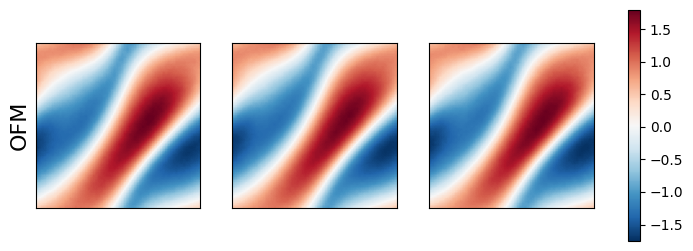

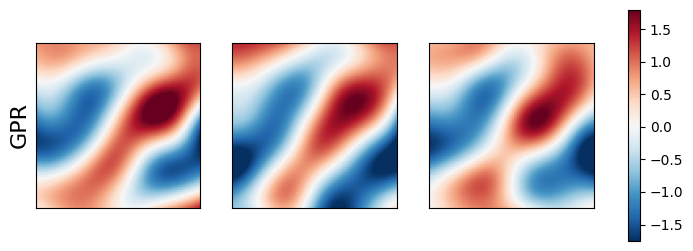

In [28]:
## each one generate 3 plots
## For the scenario, select 3 representative scenario for OpFlow and Ground Truth


random_idx = np.random.choice(len(est_samples), 3, replace=False)
fig, ax = plt.subplots(1,3, figsize=(9,3))    
for i in range(3):
    x_opflow = est_samples[random_idx[i]].squeeze()
    ax[i].imshow(x_opflow,  vmin=y_min_plot, vmax=y_max_plot, cmap="RdBu_r")
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    if i == 0:
        ax[i].set_ylabel('OFM', fontsize=16)
        
bar = ax[2].imshow(x_opflow,  vmin=y_min_plot, vmax=y_max_plot, cmap="RdBu_r")
fig.colorbar(bar, ax=ax)    
plt.savefig(f"../Regression_results/{saved_folder}/NS_reg_scen_ofm_sup.pdf")

random_idx_gt = np.random.choice(len(y_samples), 3, replace=False)
fig, ax = plt.subplots(1,3, figsize=(9,3))    
for i in range(3):
    y_example = y_samples[:,:,random_idx_gt[i]].squeeze()
    ax[i].imshow(y_example, vmin=y_min_plot, vmax=y_max_plot, cmap="RdBu_r")
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    if i == 0:
        ax[i].set_ylabel('GPR', fontsize=16)
        
bar = ax[2].imshow(y_example, vmin=y_min_plot, vmax=y_max_plot, cmap="RdBu_r")
fig.colorbar(bar, ax=ax)   
plt.savefig(f"../Regression_results/{saved_folder}/NS_reg_scen_gt_sup.pdf")


In [46]:
import h5py
f = h5py.File(f"../Regression_results/{saved_folder}/{saved_folder}.h5py", "w")
f.create_dataset('u_full_obs', data=u_obs_full.numpy())
f.create_dataset('x_obs_idx', data=mask_idx)
f.create_dataset('noise_patter', data=noise_pattern.detach().cpu().numpy().squeeze())
f.create_dataset('a_opflow_map', data=a_opflow_copy.squeeze().numpy())
f.create_dataset('sample_from_opflow', data=u_samples_all.detach().cpu().numpy())
f.close()